In [1]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [2]:
segno = 15 #number of segments, or , k for the HMM

fmri_bounds = np.zeros((10,segno-1))
reservoir_bounds = np.zeros((10,segno-1))


In [3]:
# this is a loop on 10 subjects and reservoirs that does the HMM segmentation - it is to see the variability!!


ev11 = brainiak.eventseg.event.EventSegment(segno)
for file_count in range(10):
    #fmri
    ntf_subject = np.load('ntf_tpj_data/matrix'+str(file_count+1)+'_notthefall_rev.npy')   
    ev11.fit(ntf_subject)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    fmri_bounds[file_count,:]=bounds11
    
    #reservoir
    ntf_reservoir = np.load('ntf_reservoir'+str(file_count+1)+'.npy')   
    ev11.fit(ntf_reservoir)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    reservoir_bounds[file_count,:]=bounds11

    
#fMRI bounds  [ 32  70 115 164 204 247 286 319 368] 400
#Reservoir bounds  [ 84 133 198 257 341 412 515 578 631] 682


   

[ 23  51  94 122 135 167 193 213 235 271 295 313 361 379]
[ 35  87 129 179 220 255 306 348 410 448 496 534 580 628]
[ 24  46  58  95 141 166 187 228 266 285 297 319 349 372]
[ 35  86 128 178 220 260 333 371 413 465 518 561 586 630]
[ 18  32  53  92 134 161 189 216 249 276 315 334 349 374]
[ 35  87 129 179 223 275 332 369 411 452 519 559 586 632]
[ 26  60  74  92 112 136 167 199 226 239 270 303 351 385]
[ 36  86 130 180 228 277 337 372 412 449 497 534 580 631]
[ 29  59  74  96 117 138 162 205 231 265 288 325 356 381]
[ 35  86 130 178 228 277 337 372 413 463 519 557 585 631]
[ 24  56  78  91 118 137 195 212 234 271 298 319 369 387]
[ 36  87 130 180 227 275 336 372 412 450 498 534 579 630]
[ 12  31  65 102 129 167 184 201 227 270 284 312 350 391]
[ 35  88 131 179 227 275 337 373 413 464 518 559 585 629]
[ 27  44  62  90 141 172 199 217 241 268 288 314 343 388]
[ 36  86 128 176 219 262 333 371 413 465 519 557 584 631]
[ 42  60  84  96 121 143 180 210 225 243 303 323 362 379]
[ 35  87 129 1

In [4]:
# ok so now we make the final step and do the segmenation on the averages
for file_count in range(10):
    #fmri
    ntf_subject = np.load('ntf_tpj_data/matrix'+str(file_count+1)+'_notthefall_rev.npy')   
    if file_count == 0:
        fmri_averages = ntf_subject
    else:
        fmri_averages = fmri_averages + ntf_subject
    
    #reservoir
    ntf_reservoir = np.load('ntf_reservoir'+str(file_count+1)+'.npy') 
    if file_count == 0:
        reservoir_averages = ntf_reservoir
    else:
        reservoir_averages = reservoir_averages + ntf_reservoir

reservoir_averages = reservoir_averages/10
fmri_averages = fmri_averages/10

In [5]:
for j in range(fmri_averages.shape[1]):
    mean = fmri_averages[:,j].mean()
    if abs(mean) > 0.01:
        fmri_averages[:,j] = fmri_averages[:,j]/mean

In [6]:
for j in range(reservoir_averages.shape[1]):
    mean = reservoir_averages[:,j].mean()
    if abs(mean) > 0.0005:
        reservoir_averages[:,j] = reservoir_averages[:,j]/mean

In [7]:
ev_fmri = brainiak.eventseg.event.EventSegment(segno)
ev_fmri.fit(fmri_averages)

ev_reservoir = brainiak.eventseg.event.EventSegment(segno)
ev_reservoir.fit(reservoir_averages)


EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=15)

fMRI bounds  [ 27  59  76  94 133 163 189 220 251 271 308 321 361 387]
Reservoir bounds  [ 36  87 128 179 227 277 333 371 412 449 499 534 581 629]


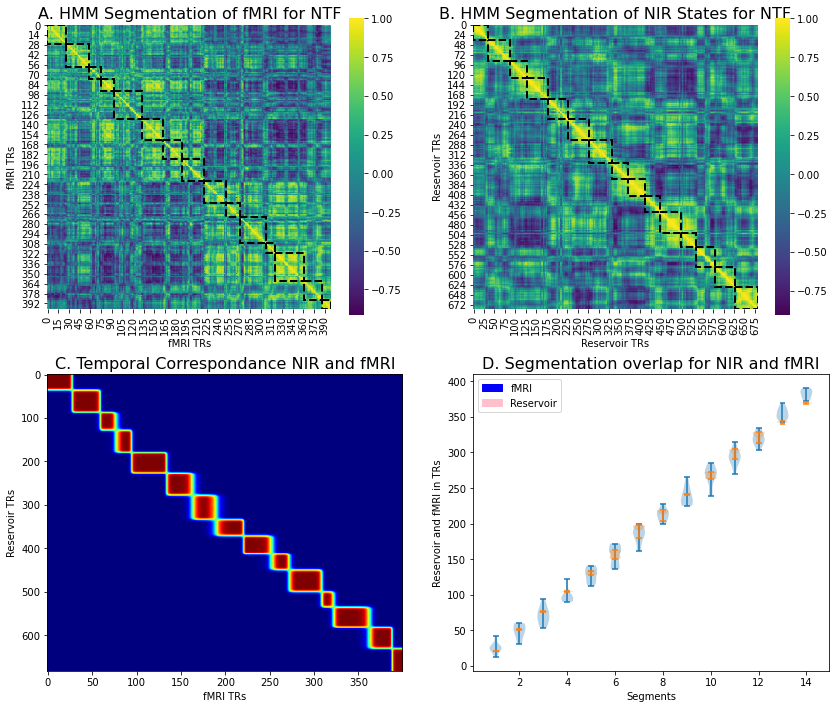

In [8]:
plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
color='jet'
edge='black'
scale1=0.999
scale2=0.9
nTR=400

#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1, origin = 'lower')
#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1)
#plt.imshow(np.corrcoef(fmri_averages))
sns.heatmap(np.corrcoef(fmri_averages),cmap='viridis', square=True)


bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('fMRI bounds ', bounds)
plt.xlabel('fMRI TRs')
plt.ylabel('fMRI TRs')

plt.title('A. HMM Segmentation of fMRI for NTF', fontsize = 16)


plt.subplot(2,2,2)

#plt.imshow(np.corrcoef(reservoir_averages),  vmin=scale2, cmap=color)
#plt.imshow(np.corrcoef(reservoir_averages))
sns.heatmap(np.corrcoef(reservoir_averages),cmap='viridis', square=True)

nTR=682
bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)

print('Reservoir bounds ', bounds)    
plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')

plt.title('B. HMM Segmentation of NIR States for NTF', fontsize = 16)


plt.subplot(2,2,3)

plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')

plt.title('C. Temporal Correspondance NIR and fMRI', fontsize = 16)



plt.subplot(2,2,4)

#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',
plt.violinplot(fmri_bounds)
plt.violinplot(reservoir_bounds/682*400)

plt.xlabel('Segments')
plt.ylabel('Reservoir and fMRI in TRs')

red_patch = patches.Patch(color='pink', label='Reservoir')
#plt.legend(handles=[red_patch], loc='upper left')

blue_patch = patches.Patch(color='blue', label='fMRI')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.title('D. Segmentation overlap for NIR and fMRI', fontsize = 16)




#fig.tight_layout()
plt.savefig('NTF-fmri-reservoir-revision-15seg.png', dpi=600)


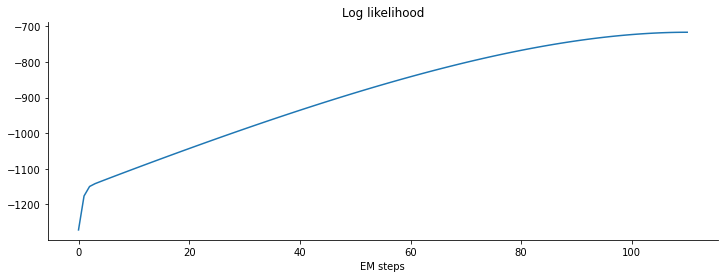

In [9]:
f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.plot(ev_reservoir.ll_)
ax.set_title('Log likelihood')
ax.set_xlabel('EM steps')
sns.despine()

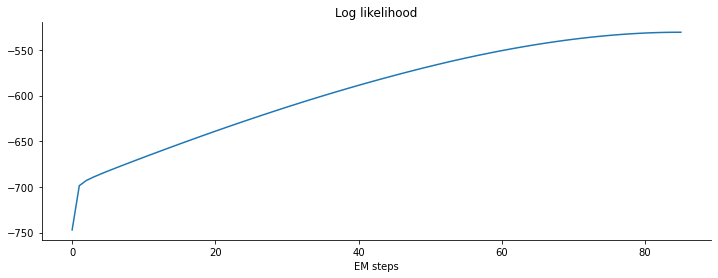

In [10]:
f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.plot(ev_fmri.ll_)
ax.set_title('Log likelihood')
ax.set_xlabel('EM steps')
sns.despine()

[ 27  59  76  94 133 163 189 220 251 271 308 321 361 387]
[ 21.1143695   51.02639296  75.07331378 104.98533724 133.13782991
 162.46334311 195.30791789 217.59530792 241.64222874 263.3431085
 292.6686217  313.19648094 340.76246334 368.91495601]
p = 0.02784851136763771


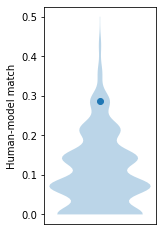

In [32]:
bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]

h_bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
h_bounds = h_bounds/682*400

print(bounds)
print(h_bounds)


np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in h_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(h_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

In [12]:
#fmri_bounds
#reservoir_bounds/682*400
i=0
for i in range(10):
    correlation, p_value = stats.pearsonr(fmri_bounds[i], reservoir_bounds[i])
    print('correltion: ',correlation)
    print('p_value: ', p_value)


correltion:  0.9974185478354429
p_value:  4.2488645813415204e-15
correltion:  0.9951917084732753
p_value:  1.7658660921612757e-13
correltion:  0.9982549447759285
p_value:  4.0618369785789047e-16
correltion:  0.9907120774452345
p_value:  9.085400538800771e-12
correltion:  0.9924458109671155
p_value:  2.6398452824753964e-12
correltion:  0.9950343389518485
p_value:  2.1415524543862235e-13
correltion:  0.9952898847732979
p_value:  1.5606077100244253e-13
correltion:  0.9950781100603712
p_value:  2.0309465254064916e-13
correltion:  0.9931430292982613
p_value:  1.4787536925380357e-12
correltion:  0.9978537630017958
p_value:  1.404623284571418e-15
